In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import random
import zipfile
import os
import skimage.transform as skt

drive.mount('/content/drive')
file_dir = "/content/drive/My Drive/horse2zebra.zip"
zipfile.ZipFile(file_dir, 'r').extractall()

Mounted at /content/drive


In [2]:
print(os.listdir(os.getcwd()))
print(os.listdir('horse2zebra'))

['.config', 'horse2zebra', 'drive', 'sample_data']
['testA', 'trainA', 'trainB', 'testB']


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


Wed Dec  2 11:06:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
def imgdir2tensor(dir):
    img = torch.FloatTensor(plt.imread(dir).copy())
    if img.ndim == 2:
        img = img.unsqueeze(2).repeat(1, 1, 3)
    return (img.transpose(0, 2) - 127.5) / 127.5

class DataSet(torch.utils.data.Dataset):
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.listdir = os.listdir(self.base_dir)

    def __len__(self):
        return 1067 #len(os.listdir('horse2zebra/trainA'))
   
    def __getitem__(self, idx):
        return imgdir2tensor(os.path.join(self.base_dir, self.listdir[idx]))

In [11]:
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size, stride, padding, padding_mode):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode, bias=False),
            nn.InstanceNorm2d(num_features=channels),
            nn.BatchNorm2d(num_features=channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode=padding_mode, bias=False),
            nn.InstanceNorm2d(num_features=channels)
        ).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x):
        return self.relu(x + self.block(x))


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(num_features=256),
            nn.ReLU()
        ).to(device)

        self.res = nn.Sequential(
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            ResBlock(channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect')
        )

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False),
            nn.InstanceNorm2d(num_features=128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False),
            nn.InstanceNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode='reflect', bias=False),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.dec(self.res(self.enc(x)))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,   64,  kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,  128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1,   kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        ).to(device)
    
    def forward(self, X):
        return self.net(X)

In [12]:
horse2zebra = Generator()
zebra2horse = Generator()
D_horse = Discriminator()
D_zebra = Discriminator()
G_solver = torch.optim.Adam(list(horse2zebra.parameters()) + list(zebra2horse.parameters()), lr=2e-4, betas=(0.5, 0.999))
D_solver = torch.optim.Adam(list(D_horse.parameters()) + list(D_zebra.parameters()),  lr=2e-4, betas=(0.5, 0.999))

In [ ]:
path = "/content/drive/My Drive/" + "horse2zebra_1.pt"
horse2zebra.load_state_dict(torch.load(path, device))
path = "/content/drive/My Drive/" + "zebra2horse_1.pt"
zebra2horse.load_state_dict(torch.load(path, device))
path = "/content/drive/My Drive/" + "D_horse_1.pt"
D_horse.load_state_dict(torch.load(path, device))
path = "/content/drive/My Drive/" + "D_zebra_1.pt"
D_zebra.load_state_dict(torch.load(path, device))

<All keys matched successfully>

In [13]:
horse_dataset = DataSet('horse2zebra/trainA')
zebra_dataset = DataSet('horse2zebra/trainB')

mbsz = 1
horse_loader = DataLoader(dataset=horse_dataset, batch_size=mbsz, shuffle=True, drop_last=True)
zebra_loader = DataLoader(dataset=zebra_dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [14]:
w_cycle = 10.0
train_Dx_true = []
train_Dx_fake = []
train_Dy_true = []
train_Dy_fake = []
train_x_cycle = []
train_y_cycle = []

In [95]:
for epoch in range(10):
    train_Dx_true.append(0.0)
    train_Dx_fake.append(0.0)
    train_Dy_true.append(0.0)
    train_Dy_fake.append(0.0)
    train_x_cycle.append(0.0)
    train_y_cycle.append(0.0)
    for (horse, zebra) in zip(horse_loader, zebra_loader):
        horse = horse.to(device)
        zebra = zebra.to(device)

        D_solver.zero_grad()
        D_horse_true = D_horse(horse)
        D_zebra_true = D_zebra(zebra)
        D_horse_fake = D_horse(zebra2horse(zebra).detach())
        D_zebra_fake = D_zebra(horse2zebra(horse).detach())
        loss = (D_horse_true - 1.0).pow(2).mean() + (D_zebra_true - 1.0).pow(2).mean() + (D_horse_fake + 1.0).pow(2).mean() + (D_zebra_fake + 1.0).pow(2).mean()
        loss.backward()
        D_solver.step()

        G_solver.zero_grad()
        horse_fake = zebra2horse(zebra)
        zebra_fake = horse2zebra(horse)

        horse_cycle = (zebra2horse(zebra_fake) - horse).abs().mean()
        zebra_cycle = (horse2zebra(horse_fake) - zebra).abs().mean()

        horse_ident = (zebra2horse(horse) - horse).abs().mean()
        zebra_ident = (horse2zebra(zebra) - zebra).abs().mean()

        loss = D_horse(horse_fake).pow(2).mean() + D_zebra(zebra_fake).pow(2).mean() +  w_cycle * (horse_cycle + zebra_cycle) + 0.5 * w_cycle * (horse_ident + zebra_ident)
        loss.backward()
        G_solver.step()

        train_x_cycle[-1] += horse_cycle.item()
        train_y_cycle[-1] += zebra_cycle.item()
        train_Dx_true[-1] += D_horse_true.mean().item()
        train_Dx_fake[-1] += D_horse_fake.mean().item()
        train_Dy_true[-1] += D_zebra_true.mean().item()
        train_Dy_fake[-1] += D_zebra_fake.mean().item()

    train_x_cycle[-1] /= len(horse_loader)
    train_y_cycle[-1] /= len(horse_loader)
    train_Dx_true[-1] /= len(horse_loader)
    train_Dx_fake[-1] /= len(horse_loader)
    train_Dy_true[-1] /= len(horse_loader)
    train_Dy_fake[-1] /= len(horse_loader)
    print(train_x_cycle[-1], train_y_cycle[-1], train_Dx_true[-1], train_Dx_fake[-1], train_Dy_true[-1], train_Dy_fake[-1])

path = "/content/drive/My Drive/"
torch.save(horse2zebra.state_dict(), path + 'horse2zebra.pt')
torch.save(zebra2horse.state_dict(), path + 'zebra2horse.pt')
torch.save(D_horse.state_dict(), path + 'D_horse.pt')
torch.save(D_zebra.state_dict(), path + 'D_zebra.pt')
print('done!')

0.15471302555924615 0.17199566148940715 0.8240600242833724 -0.8237519226374755 0.9326485096291057 -0.9323972190443108
0.14843848920946603 0.16361343785910934 0.8139623210197201 -0.8126161046039868 0.8620881918807285 -0.861021949220955
0.14919545512642945 0.16318856142705696 0.8064320995188697 -0.8055570224315738 0.857449155171675 -0.856554411372629
0.14780811050726972 0.1624206144645489 0.8082068045086802 -0.8080813954300626 0.8509231407087097 -0.8509068889944922
0.14685377033100916 0.16092827669654702 0.8011942130723845 -0.800275984296144 0.857661639599456 -0.8572625023257877
0.14568667923080217 0.16041801450905 0.7998071616618513 -0.7988844660390954 0.8490325754522342 -0.8481410387292463
0.1501225540877059 0.16151805992928642 0.8023739969837911 -0.8026442181252662 0.8740244199292282 -0.8749961030251419
0.1491974873682999 0.16324529317124714 0.8147020765197059 -0.8124046499972715 0.9062162432418097 -0.9047844406311604
0.14506884565142236 0.1613194575322043 0.8168161639624258 -0.817916

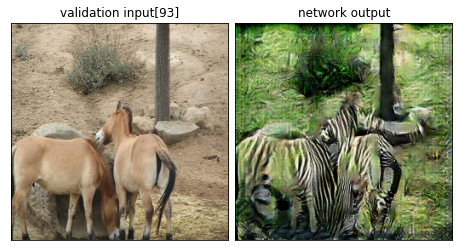

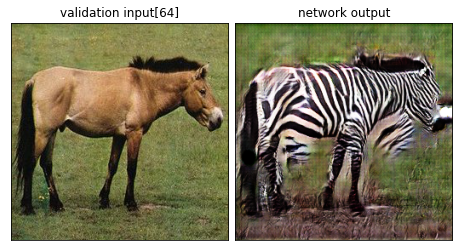

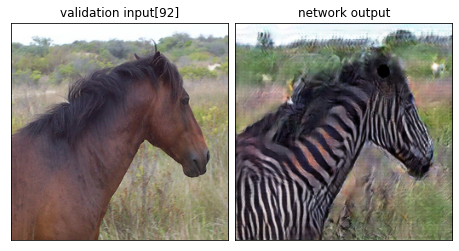

In [101]:
def validation_horse2zebra(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(os.listdir('horse2zebra/testA')))
    horse = imgdir2tensor(os.path.join('horse2zebra/testA', os.listdir('horse2zebra/testA')[idx]))
    horse2zebra.eval()
    zebra_fake = horse2zebra(horse.unsqueeze(0).to(device)).squeeze(0).cpu().detach()
    horse2zebra.train()
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('validation input[' + str(idx) + ']')
    ax.imshow((horse.transpose(0, 2) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('network output')
    ax.imshow((zebra_fake.transpose(0, 2) + 1.0) * 0.5)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()

validation_horse2zebra()
validation_horse2zebra()
validation_horse2zebra()

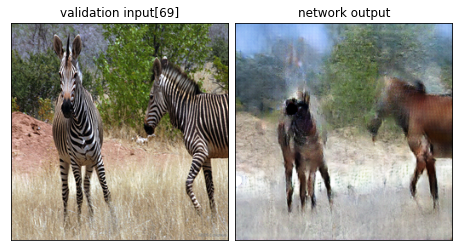

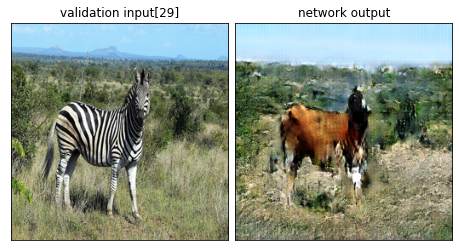

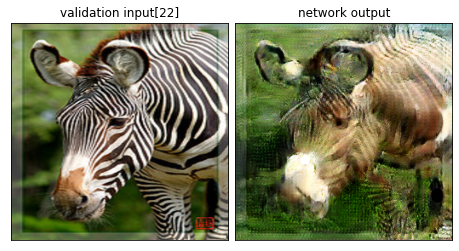

In [100]:
def validation_zebra2horse(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(os.listdir('horse2zebra/testB')))
    zebra = imgdir2tensor(os.path.join('horse2zebra/testB', os.listdir('horse2zebra/testB')[idx]))
    zebra2horse.eval()
    horse_fake = zebra2horse(zebra.unsqueeze(0).to(device)).squeeze(0).cpu().detach()
    zebra2horse.train()
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('validation input[' + str(idx) + ']')
    ax.imshow((zebra.transpose(0, 2) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('network output')
    ax.imshow((horse_fake.transpose(0, 2) + 1.0) * 0.5)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()

validation_zebra2horse()
validation_zebra2horse()
validation_zebra2horse()

In [ ]:
path = "/content/drive/My Drive/"
torch.save(horse2zebra.state_dict(), path + 'horse2zebra.pt')
torch.save(zebra2horse.state_dict(), path + 'zebra2horse.pt')
torch.save(D_horse.state_dict(), path + 'D_horse.pt')
torch.save(D_zebra.state_dict(), path + 'D_zebra.pt')
print('done!')

done!
